In [78]:
import os
import re
import pandas as pd
import numpy as np
import paramiko as pk
#import modules.title_tools as t_tools
import modules.xml_mods as xml_tools
from tqdm import tqdm
import plotnine as p9

## 1. Run 'get_remote_folder.sh' on Mercury to copy Refinitiv's files from their server onto ours.
#### Check 'get_remote_folder.py' for changes you need to make before copying!

## 2. Run 'call_getter_ref.sh' on Mercury to download the Refinitiv transcripts.
#### Remember to check log file of get_remote_folder for issues before doing this step <br /> Check 'call_getter_ref.py' for changes you need to make before downloading!

## 3. Download the new period's full transcripts and ref_master to inspect for issues before extracing paragraphs.
#### Remember to check log file of get_remote_folder for issues before doing this step <br /> You can find the file name you chose in call_getter_ref.py

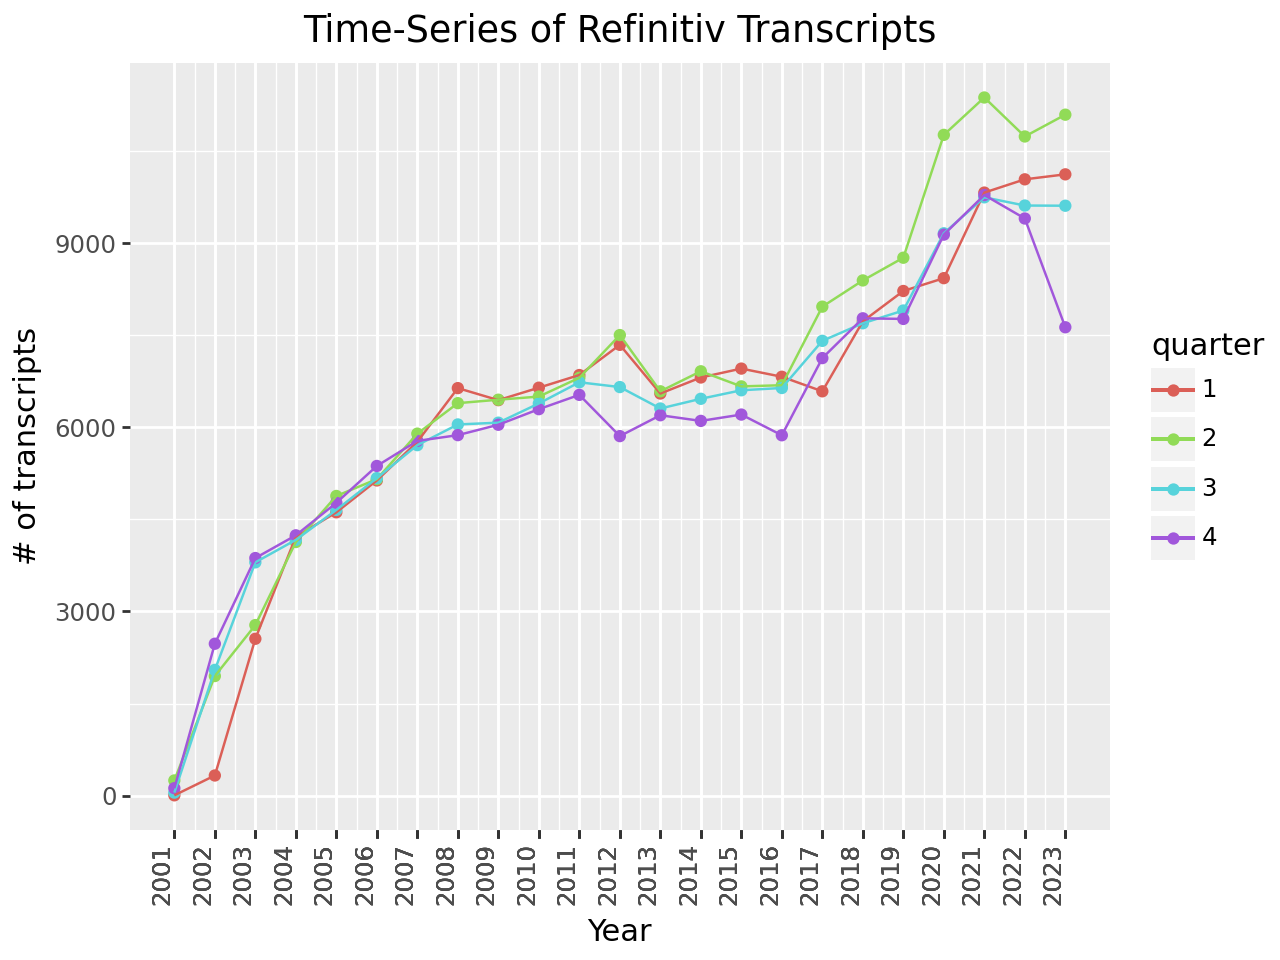

In [79]:
ref_master = pd.read_csv('../data_ref/ref_master.csv', dtype=str)

# create copy for plotting purposes
ref_master_plot = ref_master[['event_date', 'file_name']].copy()

# add year column
ref_master_plot['Year'] = pd.to_datetime(ref_master_plot.event_date).dt.year
# add quarter column
ref_master_plot['quarter'] = pd.to_datetime(ref_master_plot.event_date).dt.quarter

# create long dataset for plotting
ref_long = ref_master_plot.groupby(['Year', 'quarter']).agg(transcripts = ('file_name', 'size')).reset_index()

(
    p9.ggplot(ref_long, p9.aes(x='Year', y='transcripts', color='factor(quarter)', group='quarter'))
    + p9.geom_point()
    + p9.geom_line() 
    + p9.scale_x_continuous(name='Year', breaks = ref_long.Year)
    + p9.scale_y_continuous(name='# of transcripts', limits=[ref_long.transcripts.min(), ref_long.transcripts.max()])
    + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1))
    + p9.ggtitle('Time-Series of Refinitiv Transcripts')
    + p9.labs(color='quarter')
)

# Scratch

In [4]:
# use this space for testing

df_2001_2021 = pd.read_csv('./temp_check/all_refinitiv_trans_2001-2021.csv', index_col=0) # contains 2001-2021. Larger due to pdf ref comparison data
#### date-added: 2023-01-09
df_2001_2022 = pd.read_csv('./temp_check/all_refinitiv_trans_2001-2022.csv', index_col=0) # contains 2001-2022.
#### date-added: 2023-03-27

# FULLEST
df_2001_2023 = pd.read_csv('./temp_check/all_refinitiv_trans_2001-2023.csv') # contains 2001-2023. 
#### date_added: 2024-03-08
# FULLEST

df_2001_2023_firsthalf = pd.read_csv('./temp_check/all_refinitiv_trans_2001-2023-firsthalf.csv', index_col=0) # full set through May 2023
#### date_added: 2023-06-30
df_2001_2023_q3 = pd.read_csv('./temp_check/all_refinitiv_trans_2001-2023-q3.csv', index_col=0) # full set through May 2023
#### date_added: 2023-10-26
df_2001_2023_q4 = pd.read_csv('./temp_check/all_refinitiv_trans_2001-2023-q4.csv', index_col=0) # def contains df23, df24, but NOT df23_full
#### date_added: 2024-01-30

df23_q3 = pd.read_csv('./temp_check/all_refinitiv_trans_2023-q3.csv', index_col=0) # seems to be mostly q3 + June
#### date_added: 2023-10-26
df23_q4 = pd.read_csv('./temp_check/all_refinitiv_trans_2023-q4.csv', index_col=0) # seems to be mostly q4 (missing last months as we know)
#### date_added: 2024-01-25
df23_full = pd.read_csv('./temp_check/all_refinitiv_trans_2023_full_transcripts.csv') # mostly q4 with only last months
#### date_added: 2024-03-08

# so df23_full + df23_q4 is full q4 of 2023

In [5]:
df_2001_2021_clean = df_2001_2021[['file_name', 'firm_id', 'firm_name', 'event_title', 'event_date']].copy()
df_2001_2021_clean.rename(columns={'firm_id': 'cusip'}, inplace=True)
df_2001_2021_clean.event_date = pd.to_datetime(df_2001_2021_clean.event_date).dt.date
df_2001_2021_clean['date_added'] = '2023-01-09'
df_2001_2022['date_added'] = '2023-03-27'
ref_master = pd.concat([df_2001_2021_clean, df_2001_2022]).sort_values('date_added').drop_duplicates(subset='file_name').reset_index(drop=True)

df_2001_2023_firsthalf['date_added'] = '2023-06-30'
ref_master = pd.concat([ref_master, df_2001_2023_firsthalf]).sort_values('date_added').drop_duplicates(subset='file_name').reset_index(drop=True)

df_2001_2023_q3['date_added'] = '2023-10-26'
ref_master = pd.concat([ref_master, df_2001_2023_q3]).sort_values('date_added').drop_duplicates(subset='file_name').reset_index(drop=True)

df_2001_2023_q4['date_added'] = '2024-01-30'
ref_master = pd.concat([ref_master, df_2001_2023_q4]).sort_values('date_added').drop_duplicates(subset='file_name').reset_index(drop=True)

df_2001_2023['date_added'] = '2024-03-08'
ref_master = pd.concat([ref_master, df_2001_2023]).sort_values('date_added').drop_duplicates(subset='file_name').reset_index(drop=True)

ref_master = ref_master[['file_name', 'cusip', 'isin', 'firm_name', 'event_title', 'event_date', 'date_added']]
ref_master

,file_name,cusip,isin,firm_name,event_title,event_date,date_added
0,5445258_T.xml,NaN,NaN,Lundin Petroleum AB,Q2 2014 Lundin Petroleum AB Earnings Call,2014-08-06,2023-01-09
1,959182_T.xml,931427108,NaN,Walgreens Boots Alliance Inc,"Q3 2004 Option Care, Inc. Earnings Conference ...",2004-11-04,2023-01-09
2,957624_T.xml,296315104,NaN,ESCO Technologies Inc,Q4 2004 ESCO Technologies Inc. Earnings Confer...,2004-11-16,2023-01-09
3,905669_T.xml,NaN,NaN,California Micro Devices Corp,Q1 2005 California Micro Devices Corp Earnings...,2004-07-29,2023-01-09
4,3450927_T.xml,NaN,NaN,Brisa Auto Estradas de Portugal SA,"Brisa-Auto Estradas de Portugal, S.A. Corporat...",2010-10-18,2023-01-09
...,...,...,...,...,...,...,...
584082,15611399_T.xml,NaN,NaN,Bancolombia SA,Q3 2023 Bancolombia SA Earnings Call,2023-11-09,2024-03-08
584083,15794390_T.xml,118440106,NaN,Buckle Inc,Q3 2023 Buckle Inc Earnings Call,2023-11-17,2024-03-08
584084,15511752_T.xml,05534B760,NaN,BCE Inc,Q3 2023 BCE Inc Earnings Call,2023-11-02,2024-03-08
584085,15694125_T.xml,NaN,NaN,NXP Semiconductors NV,NXP Semiconductors NV at UBS Technology Confer...,2023-11-28,2024-03-08
